In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import os
from google.colab.patches import cv2_imshow
from keras.models import load_model
import numpy as np

In [3]:
%cd /content/drive/MyDrive/Yeast

/content/drive/MyDrive/Yeast


###*Crop ảnh trong train*

In [4]:
def crop_cell(images_folder,mask_folder,image_path, mask_path, save_folder):
  # for origin_image in os.listdir(origin_image_folder):
    #print(dem1)
    anh_goc = cv2.imread(os.path.join(images_folder,image_path))
    # print(os.path.join(images_folder,image_path))
    mask = cv2.imread(os.path.join(mask_folder, mask_path))
    # print(os.path.join(mask_folder, mask_path))
    #cnt = 0
    anh_xam = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret,nguong1 = cv2.threshold(anh_xam, 127, 255, cv2.THRESH_BINARY)
    nguong2 = cv2.bitwise_not(nguong1)
    contours, _ = cv2.findContours(nguong2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    MIN_HEIGHT = 4
    MAX_HEIGHT = anh_goc.shape[0] *0.5

    for contour in contours[:-1]:
      x,y,w,h = cv2.boundingRect(contour)
      tam_x = x + h/2
      tam_y = y + w/2
      if w > MIN_HEIGHT and w <MAX_HEIGHT:
        #cnt += 1
        crop_number = anh_goc[y:y+h, x:x+w]
        saved_path = save_folder + f'/{image_path.split(".")[0]}_({tam_x},{tam_y})_({w}_{h}).png'
        # cv2_imshow(crop_number)
        cv2.imwrite(saved_path, crop_number)
    # cv2_imshow(anh_goc)
    # cv2.imwrite(os.path.join(save_folder, "predicted_cell" + image_path), anh_goc)
# print(len(train_anh_goc_list))
# print(len(train_watershed_mask_list))

In [5]:
image_folder = "dataset/non-aug/train/images"
mask_folder = "dataset/non-aug/train/mask"
save_folder = "Cropped_Cell"

In [6]:
image_path_list =  os.listdir(image_folder)
mask_path_list = os.listdir(mask_folder)
image_path_list = sorted(image_path_list)
mask_path_list = sorted(mask_path_list)

In [7]:
for i in range(len(image_path_list)):
  crop_cell(image_folder, mask_folder, image_path_list[i], mask_path_list[i], save_folder)

In [8]:
count = os.listdir(save_folder)
print(len(count))

3511


###*Predict crop image*

In [ ]:
def pad_image(image_path, target_size):
    # Đọc ảnh từ đường dẫn
    img = cv2.imread(image_path)

    # Kiểm tra nếu ảnh được đọc thành công
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")

    # Lấy kích thước hiện tại của ảnh
    h, w = img.shape[:2]

    # Tính toán số lượng padding cần thiết
    pad_h = max(0, (target_size[0] - h) // 2)
    pad_w = max(0, (target_size[1] - w) // 2)

    ex1 = (target_size[0] - h) % 2
    ex2 = (target_size[1] - w) % 2
    # Pad ảnh sao cho kích thước đạt target_size
    padded_img = cv2.copyMakeBorder(
        img,
        pad_h, pad_h + ex1, pad_w, pad_w +ex2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Padding với màu đen (giá trị 0)
    )

    # Cắt ảnh nếu kích thước vượt quá target_size sau padding
    padded_img = padded_img[:target_size[0], :target_size[1]]

    return padded_img

In [ ]:
train_origin_image_folder = '/content/drive/MyDrive/Yeast/dataset/non-aug/train/images'
train_watershed_mask_folder = '/content/drive/MyDrive/Yeast/dataset/non-aug/train/watershed_mask'
train_cropped_cells_folder = '/content/drive/MyDrive/Yeast/dataset/non-aug/train/cropped_cells'

In [ ]:
train_anh_goc_list = sorted(os.listdir(train_origin_image_folder))
train_watershed_mask_list = sorted(os.listdir(train_watershed_mask_folder))

In [ ]:
def pad_img(img, target_size):
    # Lấy kích thước hiện tại của ảnh
    h, w = img.shape[:2]

    # Tính toán số lượng padding cần thiết
    pad_h = max(0, (target_size[0] - h) // 2)
    pad_w = max(0, (target_size[1] - w) // 2)

    ex1 = (target_size[0] - h) % 2
    ex2 = (target_size[1] - w) % 2
    # Pad ảnh sao cho kích thước đạt target_size
    padded_img = cv2.copyMakeBorder(
        img,
        pad_h, pad_h + ex1, pad_w, pad_w +ex2,
        borderType=cv2.BORDER_CONSTANT,
        value=0  # Padding với màu đen (giá trị 0)
    )

    # Cắt ảnh nếu kích thước vượt quá target_size sau padding
    padded_img = padded_img[:target_size[0], :target_size[1]]

    return padded_img

1/1 [==============================] - 0s 21ms/step


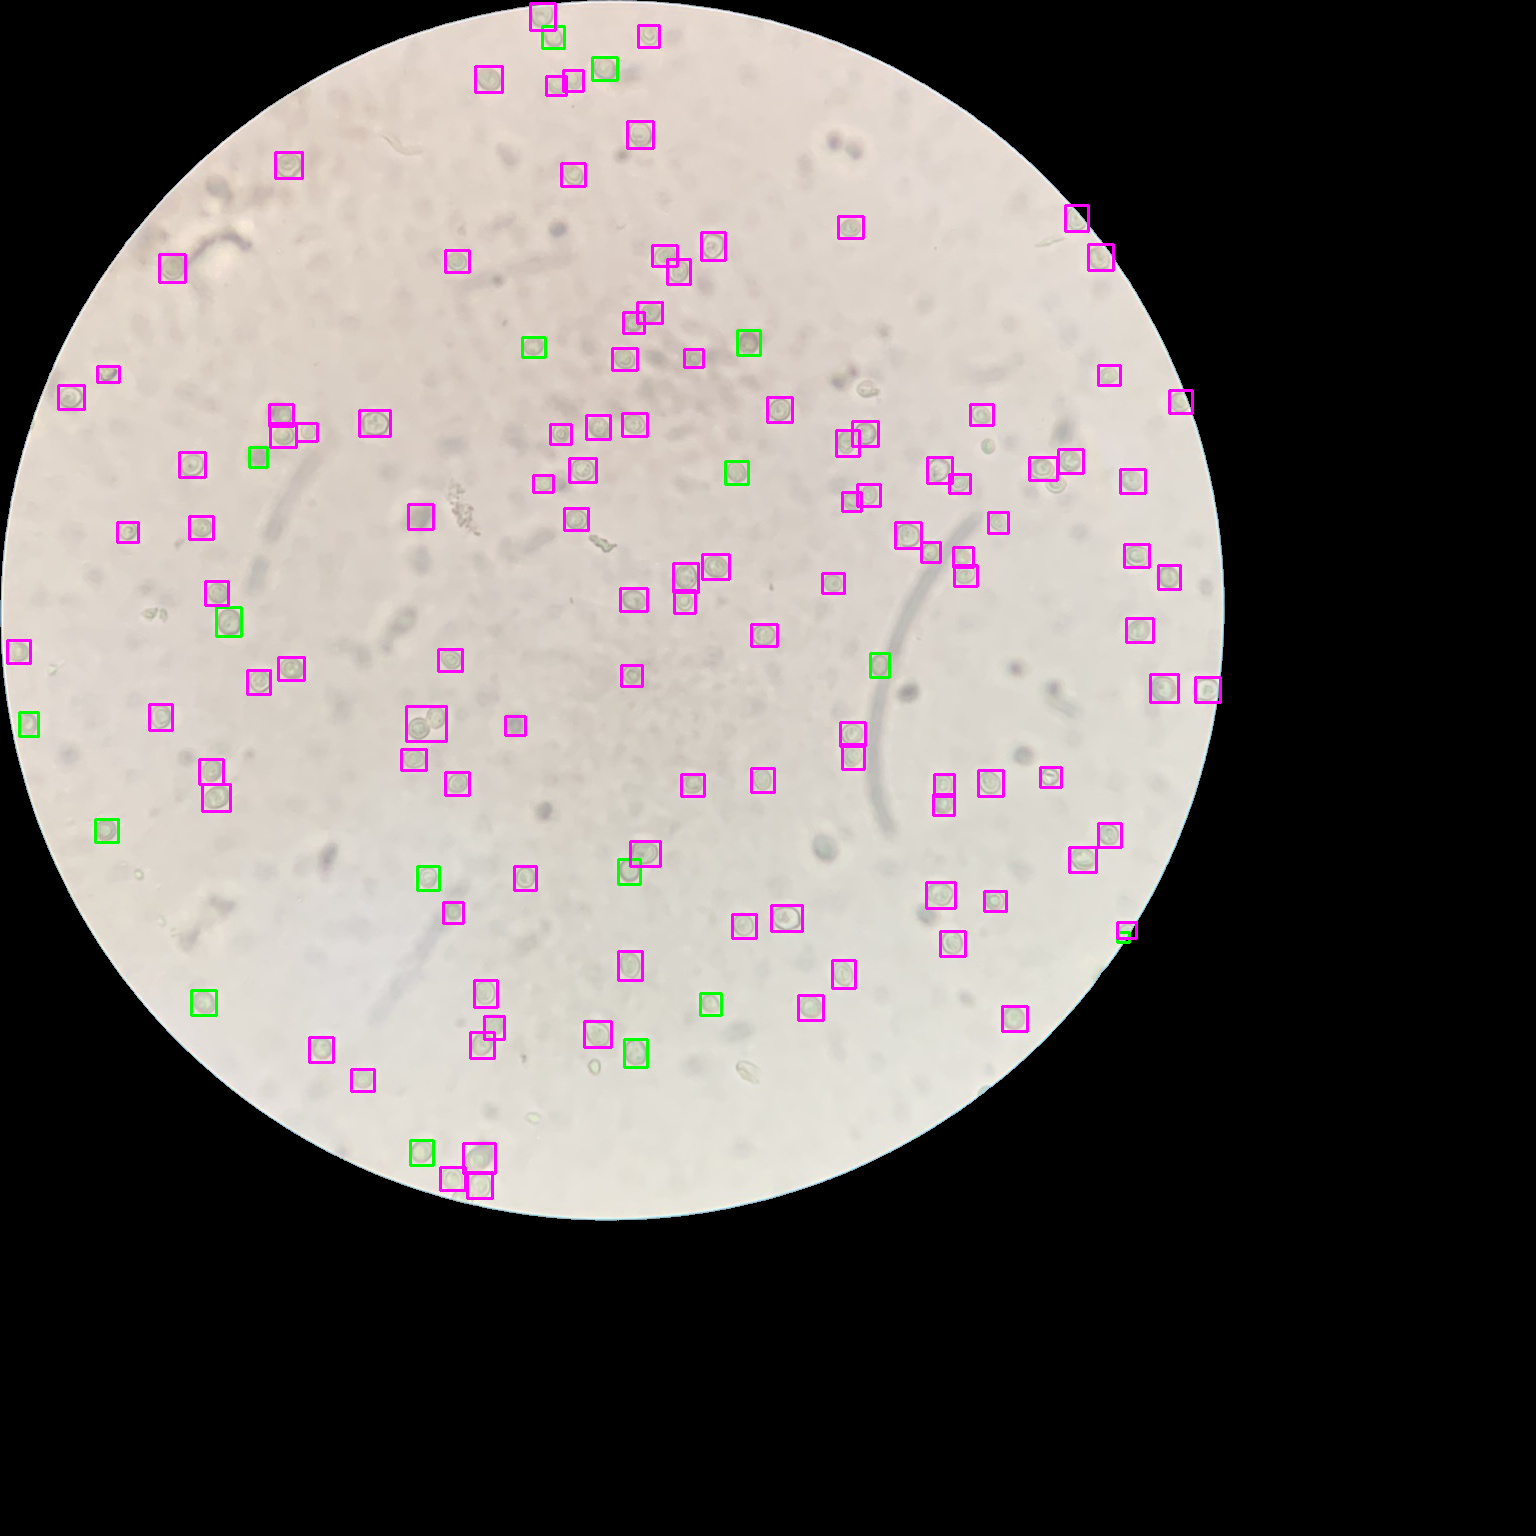

In [ ]:
train_anh_goc_list = sorted(os.listdir(train_origin_image_folder))
train_watershed_mask_list = sorted(os.listdir(train_watershed_mask_folder))
model = load_model('files/non-aug/best_yeast_classification_model.hdf5')
def predict(dem1,origin_image_file, watershed_mask_file, cropped_cells_folder):
  # for origin_image in os.listdir(origin_image_folder):
    #print(dem1)
    anh_goc = cv2.imread(os.path.join(train_origin_image_folder,origin_image_file))
    watershed = cv2.imread(os.path.join(train_watershed_mask_folder, watershed_mask_file))

    anh_xam = cv2.cvtColor(watershed, cv2.COLOR_BGR2GRAY)
    ret,nguong1 = cv2.threshold(anh_xam, 127, 255, cv2.THRESH_BINARY)
    nguong2 = cv2.bitwise_not(nguong1)
    contours, _ = cv2.findContours(nguong2, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    MIN_HEIGHT = 4
    MAX_HEIGHT = anh_goc.shape[0] *0.5
    dem = 0
    # anh_goc2 = anh_goc.copy()
    # mask_3_channels = cv2.merge([nguong1] * 3)

    for cnt in contours[:-1]:
      x,y,w,h = cv2.boundingRect(cnt)
      if w > MIN_HEIGHT and w <MAX_HEIGHT:
        dem +=1
        crop_number = anh_goc[y-1:y+h+1, x-1:x+w+1]
        pad_image(crop_number, (32, 32))
        label = model.predict(np.expand_dims(crop_number, axis=0))
        if(label == 0) :
          cv2.rectangle(anh_goc, (x, y), (x + w, y + h), (0, 255, 0), 2)
        else:
          cv2.rectangle(anh_goc, (x, y), (x + w, y + h), (0, 0, 255), 2)
        # saved_path = cropped_cells_folder+ '/{}_{}.png'.format(dem1, dem)
        # cv2_imshow(crop_number)
        #cv2.imwrite(saved_path, crop_number)
    cv2_imshow(anh_goc)
# print(len(train_anh_goc_list))
# print(len(train_watershed_mask_list))
for i in range(1):
  train_anh_goc = train_anh_goc_list[i]
  train_watershed_mask = train_watershed_mask_list[i]
  predict(i+1, train_anh_goc, train_watershed_mask, train_cropped_cells_folder)

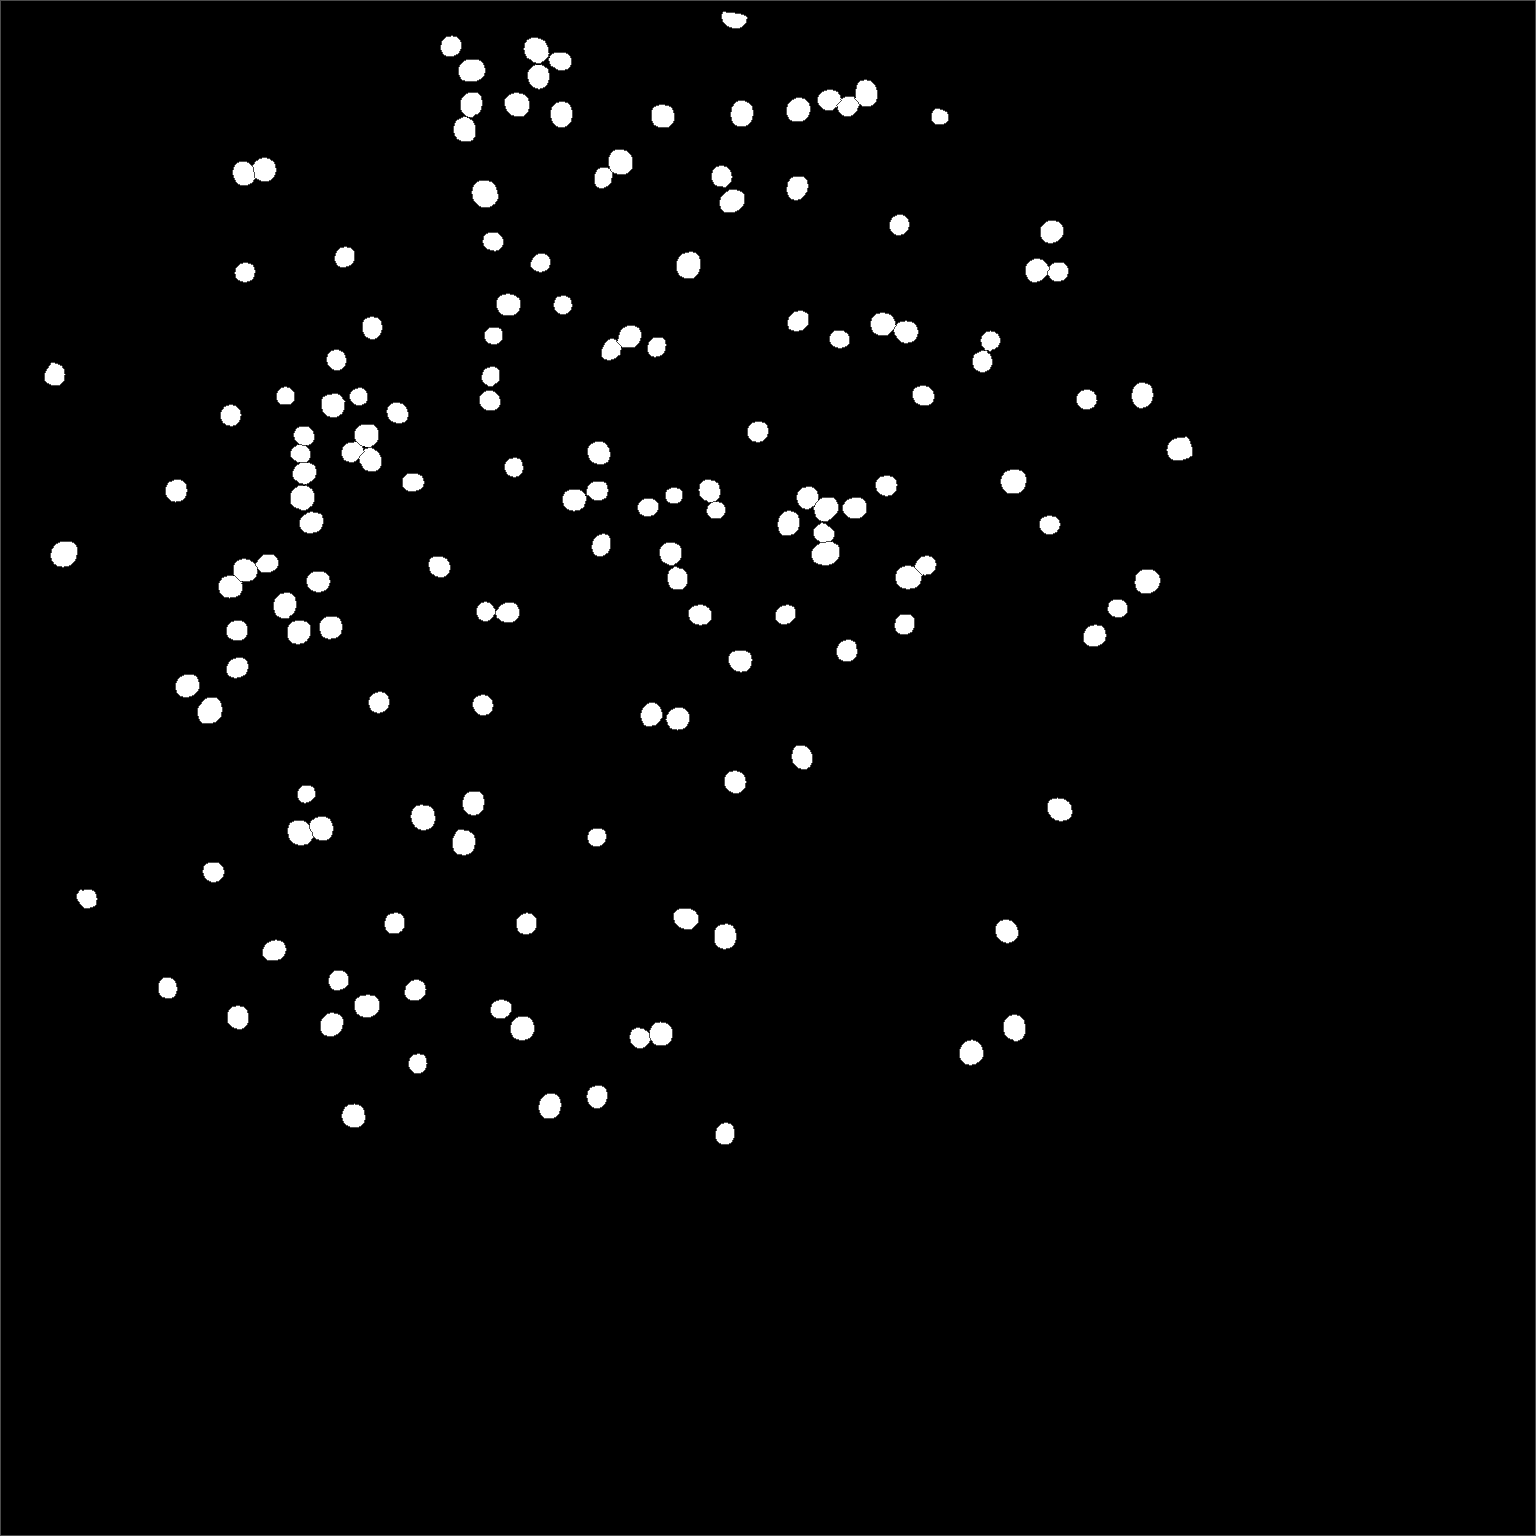

In [ ]:
anh_xam = cv2.cvtColor(watershed, cv2.COLOR_BGR2GRAY)
cv2_imshow(anh_xam)

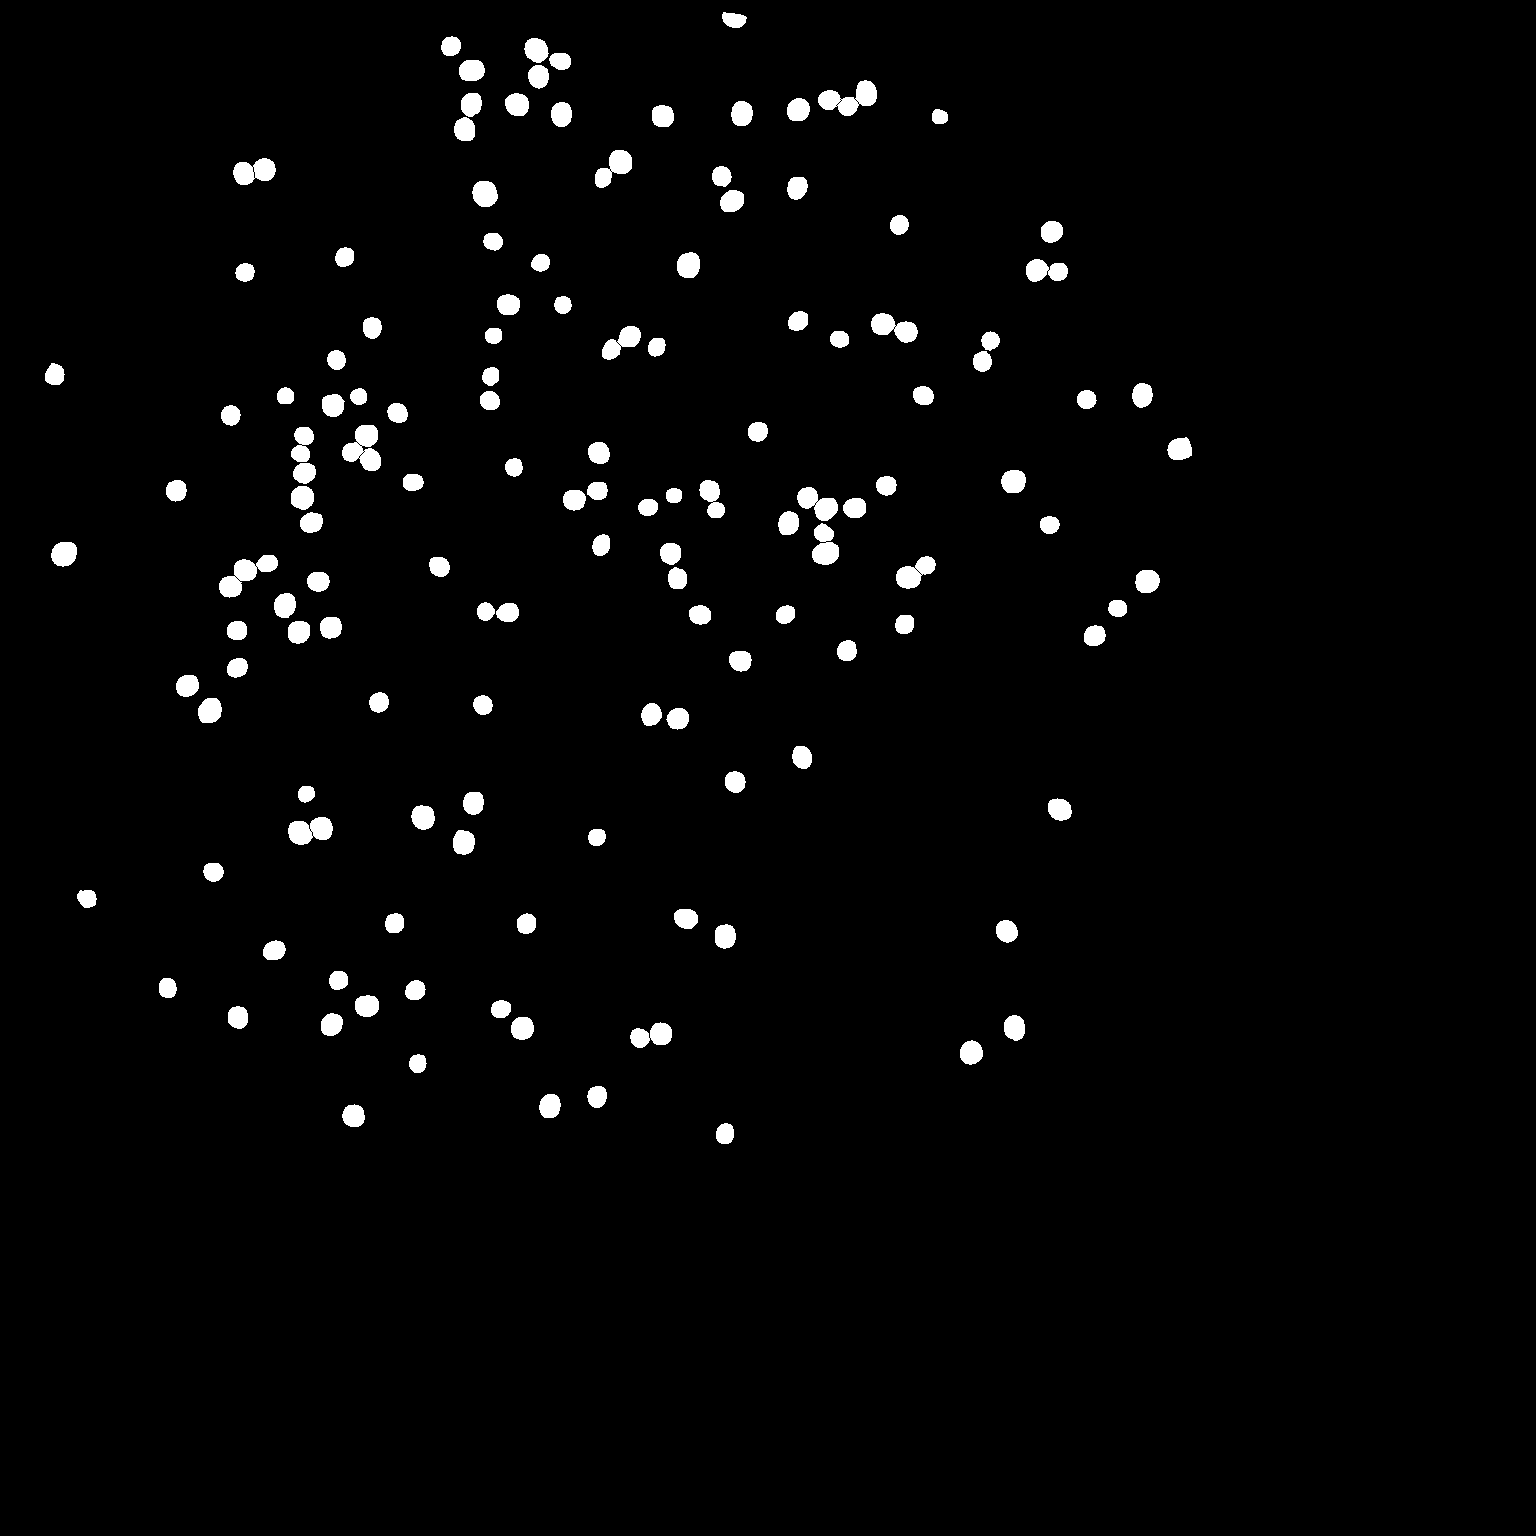

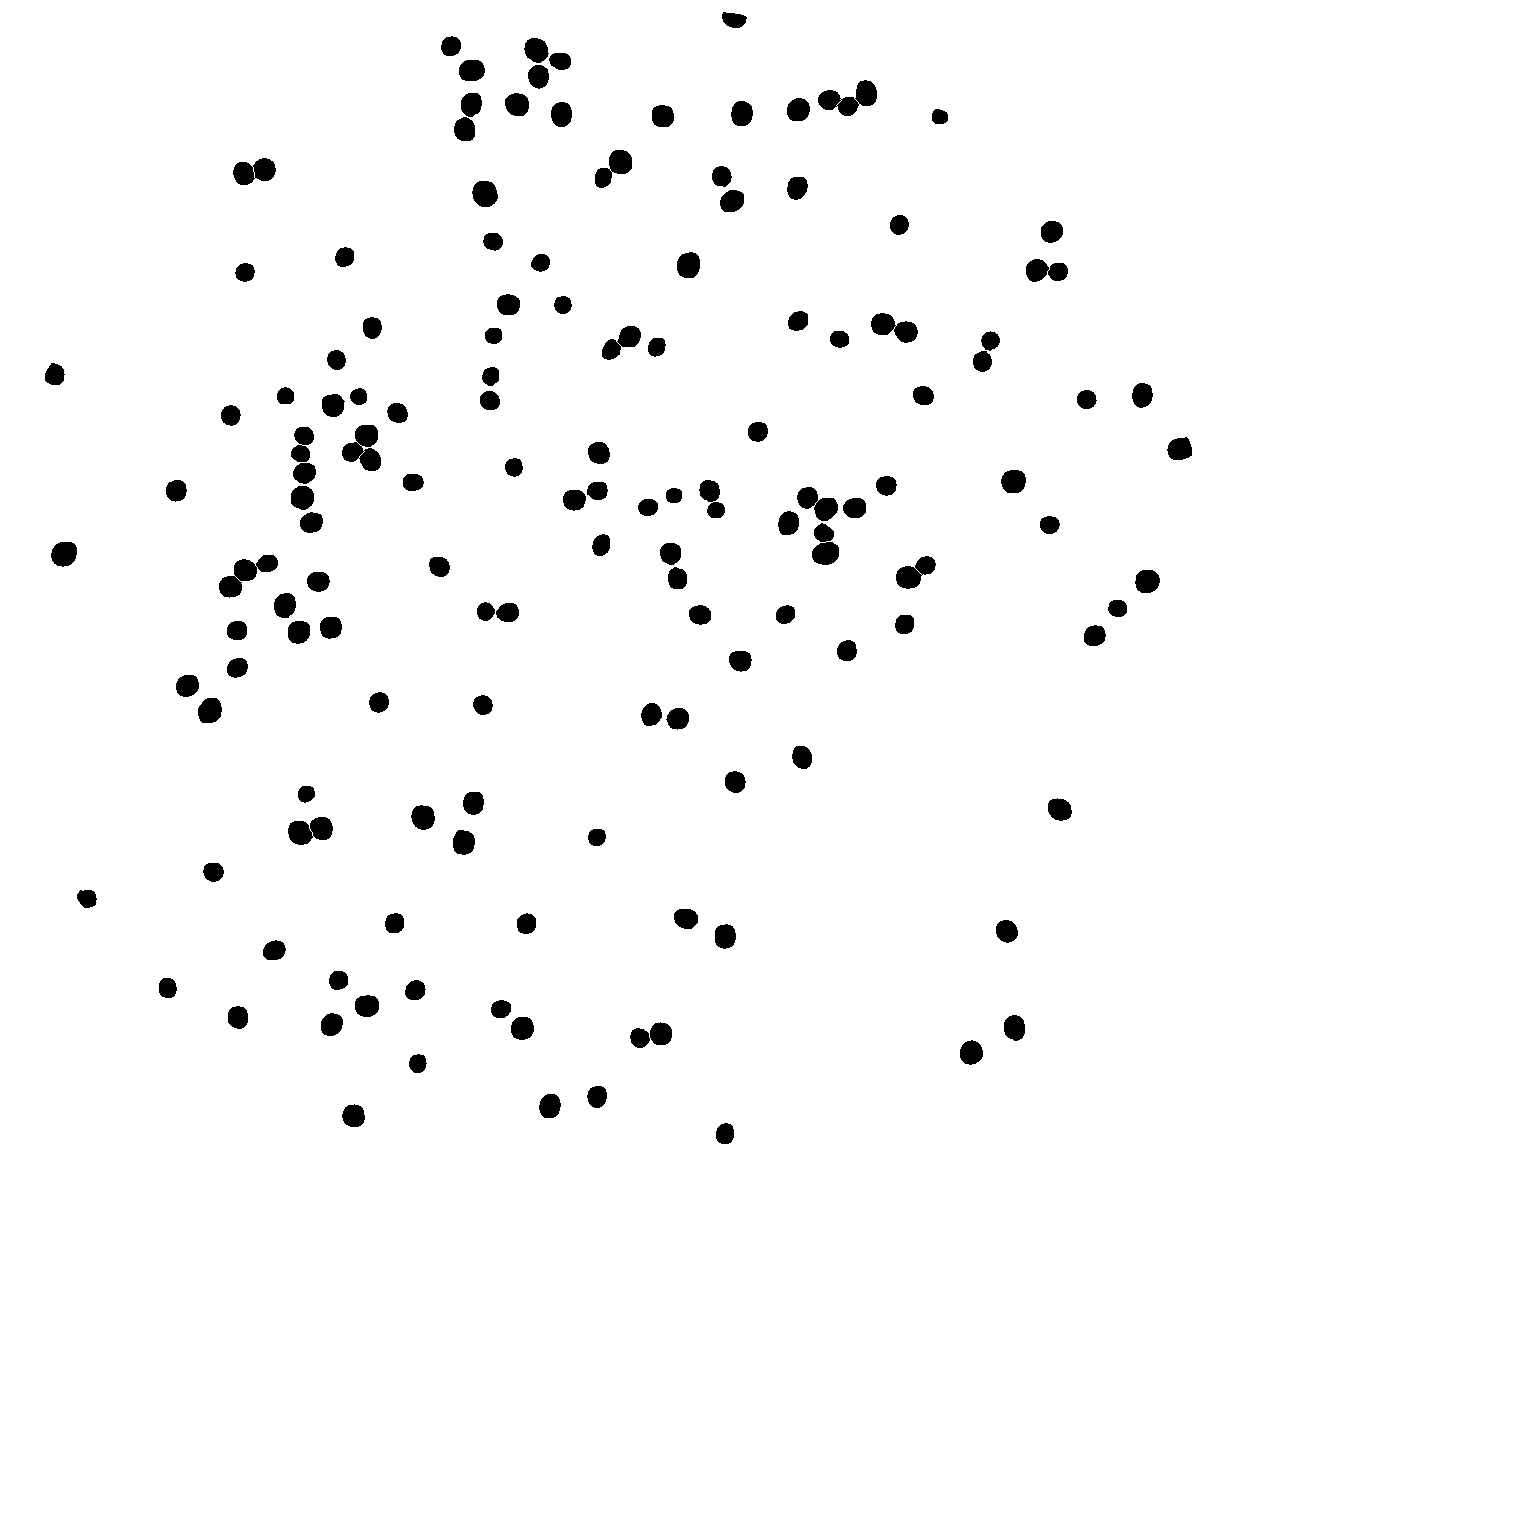

In [ ]:
ret,nguong = cv2.threshold(anh_xam, 127, 255, cv2.THRESH_BINARY)
cv2_imshow(nguong)
nguong = cv2.bitwise_not(nguong)
cv2_imshow(nguong)

In [ ]:
cd '/content/drive/MyDrive/Colab Notebooks/test'

/content/drive/MyDrive/Colab Notebooks/test


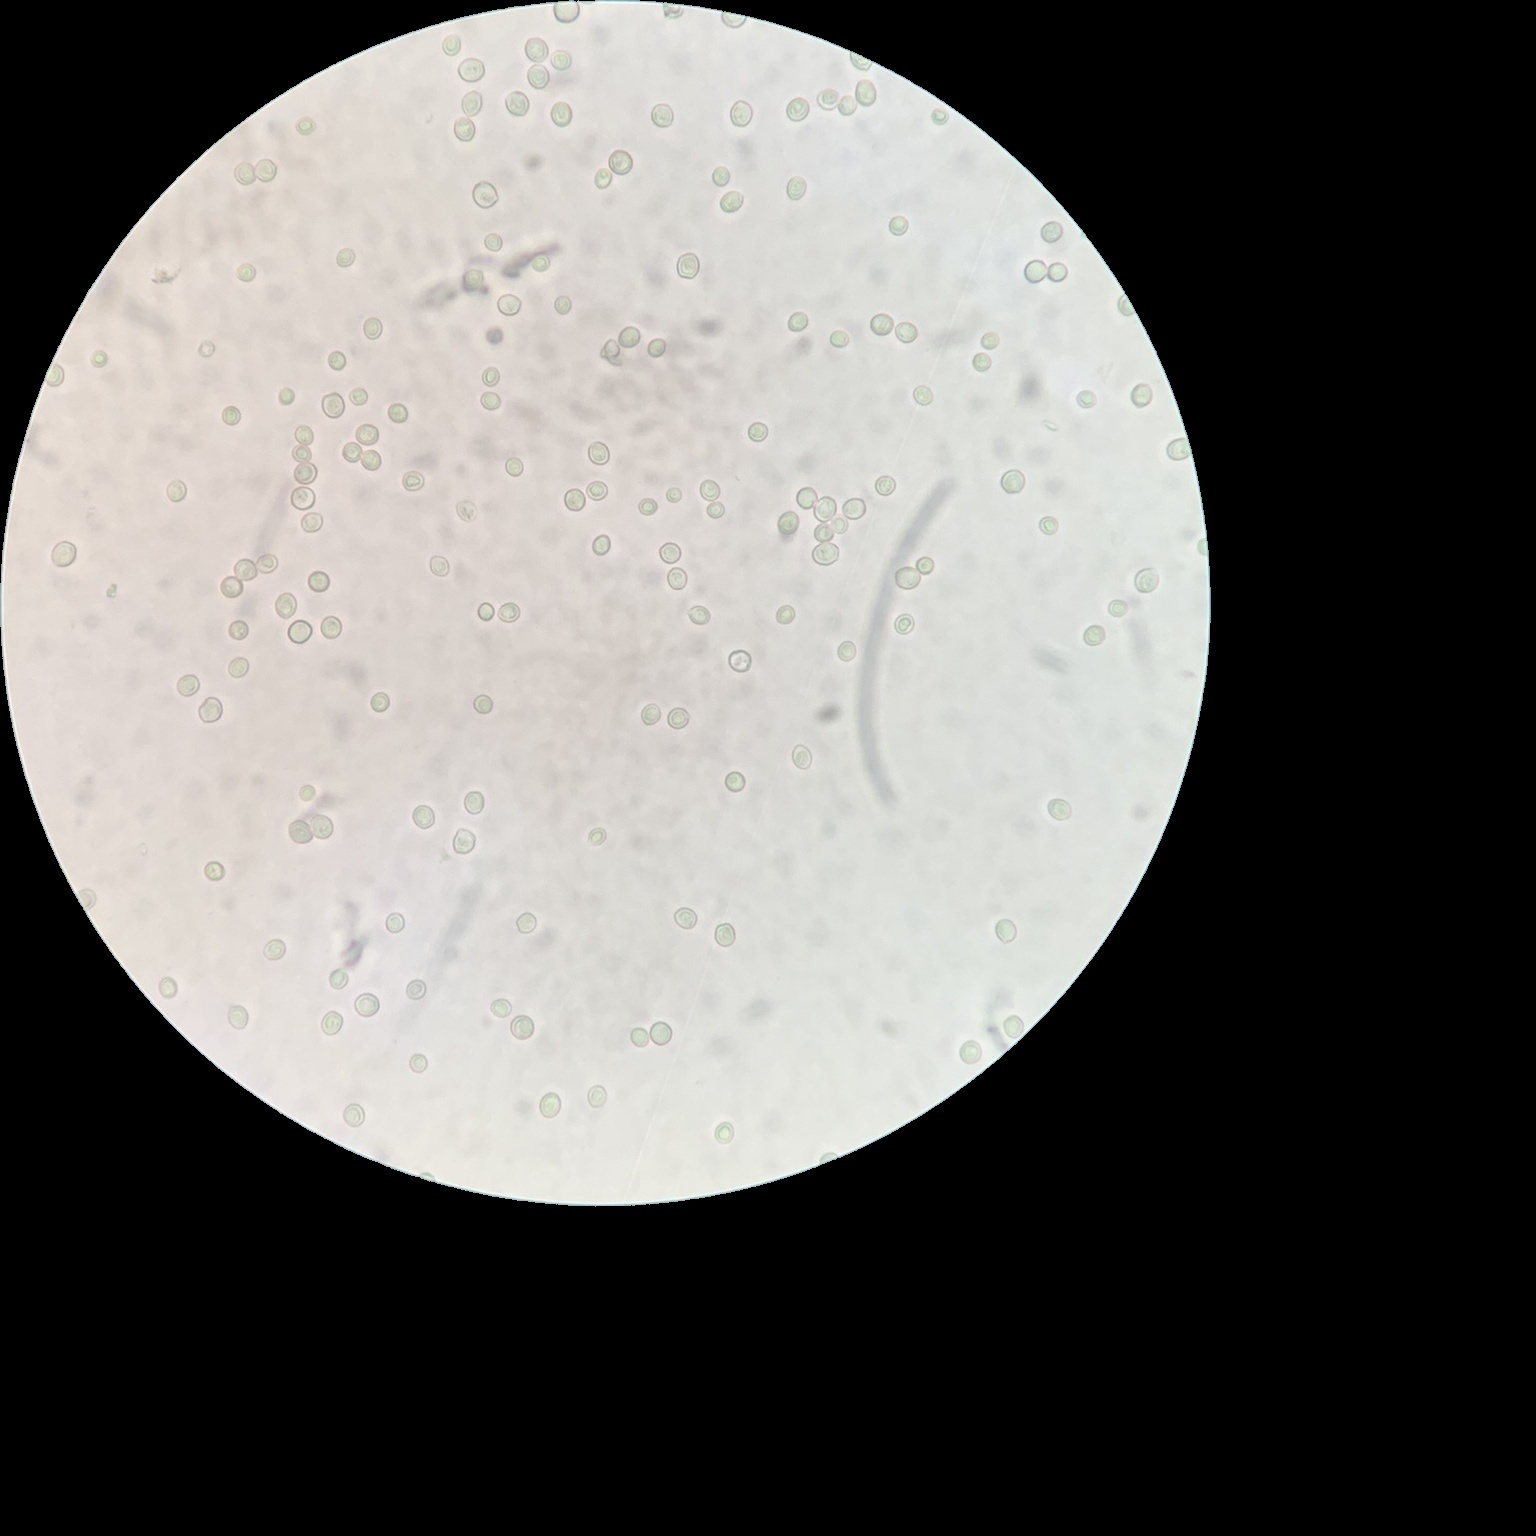

In [ ]:
contours, _ = cv2.findContours(nguong, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
MIN_HEIGHT = 4
MAX_HEIGHT = anh_goc.shape[0] *0.5
dem =0

for cnt in contours[:-1]:
  x,y,w,h = cv2.boundingRect(cnt)
  if w > MIN_HEIGHT and w <MAX_HEIGHT:
    dem +=1
    crop_number = anh_goc[y:y+h, x:x+w]
    # print(dem)
    cv2.imwrite('{}.png'.format(dem), crop_number)

    # cv2.drawContours(anh_goc, [cnt], -1, (0, 0, 255), 1, cv2.LINE_AA)
    # cv2_imshow(crop_number)
# cv2_imshow(anh_goc)